In [1]:
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
import surface_general_defect
from simple_grid import chiplet

### 1. Allocate a chiplet with the desired ideal code distance, and randomly sample the defect locations

In [28]:
# if it doesn't have defect, this chiplet will have distance 9
c = chiplet(9)
# each link will be assigned broken with a 2% chance
c.set_err_fixed_freq(0.02)
# print out the coordinates of the defective qubits
print(c.list_defects_in_patch()) 

[(0, 6), (4, 12), (12, 4), (16, 2), (16, 14)]


In [33]:
c = chiplet(9)
# alternatively, we can assign both links and qubits to be broken
# in this case each link or qubit is assigned broken at a 1% chance
c.set_err_tunable(0.01,0.01)
print(c.list_defects_in_patch())

[(3, 11), (6, 8), (12, 4)]


### 2. Generate the logical qubit instance. Input: size of the qubit, locations of defects, and the physical error rates of the gates.

Initializer of the LogicalQubit will adapt the surface code to the given defect distribution. If the proportion of defects is so high that one of the two following scenarios happen, the initializer will halt and throw an exception: (1) more than half of the physical data qubits have been disabled, (2) an entire boundary needs to be shifted at once. Both cases are extremely unlikely under realistic assumption of defect rate.

In [2]:
# defect locations copied from part 1
faulty_qubits = [(3, 11), (6, 8), (12, 4)]
# size of the qubit, needs to be aligned with the one used to generate the defect locations
d=9
# the error rate of each 2-qubit gate
p = 0.001
# generate the logical qubit instance
logical_qubit = surface_general_defect.LogicalQubit(d, 8./15.*p, 0.8*p, p, missing_coords=faulty_qubits,get_metrics=True)

Print out some parameters of the adapted patch:

In [3]:
print("vertical distance:",logical_qubit.actual_distance_vertical())
print("horizontal distance:",logical_qubit.actual_distance_horizontal())
print("diameter of the largest cluster:", logical_qubit.diameter_biggest_cluster())
print("num of defect clusters in the interior:",logical_qubit.num_clusters())
print("num of disabled data qubits:", logical_qubit.num_disabled_data())
print('num of shortest logical operators (vertical and horizontal):',logical_qubit.all_shortest_paths_v, logical_qubit.all_shortest_paths_h)

vertical distance: 5
horizontal distance: 6
diameter of the largest cluster: 3
num of defect clusters in the interior: 2
num of disabled data qubits: 10
num of shortest logical operators (vertical and horizontal): 16 210


In [4]:
# print the gauges around each defect cluster
logical_qubit.print_gauges()

cluster: 0  diameter= 3
Data qubits in the defect cluster: [13, 14, 15, 22, 23, 24, 31, 32, 33]
X gauges: [89, 91, 100, 107, 116, 118]
Z gauges: [90, 92, 97, 110, 115, 117]
cluster: 1  diameter= 1
Data qubits in the defect cluster: [56]
X gauges: [132, 141]
Z gauges: [131, 142]


### 3. Generate a memory experiment circuit.

In [38]:
# if there's no defect in the interior of the patch
if len(logical_qubit.defect) == 0:
    # no need to use "shells"
    circuit = logical_qubit.generate_stim(d)
# if there are interior defects
else:
    # generate the circuit with "shells"
    circuit = logical_qubit.generate_stim_shell(d)

Stim can print out a diagram showing a slice of the circuit. With the time step we choose, the diagram usually gives a good sense of what the adapted patch looks like.

But note that it doesn't show the super-stabilizers in the same way we do in the paper.

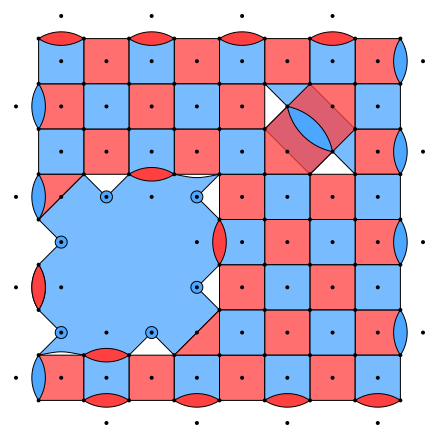

In [39]:
circuit.diagram("detector-slice-svg", tick=8)

We can use the circuit generated above to perform memory experiments.

In [40]:
defect_tasks = [sinter.Task(circuit=circuit,detector_error_model=circuit.detector_error_model(decompose_errors=True),
                                        json_metadata={'d': d, 'p': p})]
defect_stats: List[sinter.TaskStats] = sinter.collect(
        num_workers=4, # set the number of threads to use
        tasks=defect_tasks,
        decoders=['pymatching'],
        max_shots=10000 # set the number of shots for the experiment
    )

In [43]:
# print out the experiment results: the logical error rates
ler = []
for sample in defect_stats:
    ler.append(float(sample.errors)/float(sample.shots))
print(ler)

[0.0092]
